# Линейные методы классификации и регрессии: метод стохастического градиента

## Библиотеки

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy.special import expit
from tqdm.notebook import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import torch

from sklearn.linear_model import (LogisticRegression,
                                  LinearRegression)
from sklearn.model_selection import LeaveOneOut, KFold

## Оптимизационные задачи

### Задача оптимизации
Задачи машинного обучения всегда сводятся к решению некоторой задачи оптимизации:
$$
\hat{\mathbf{w}} = \arg\min_{\mathbf{w} \in \mathcal{W}} \mathcal{L}\bigr(\mathbf{w}, \mathbf{X}, \mathbf{y}\bigr).
$$

Обычно данные задачи оптимизации решают двумя способами:
1. Аналитическое решение.
2. Стохастический градиентный спуск.

Аналитическое решение имеет самый большой недостаток в том, что не для любого $\mathcal{L}$ оно существует или может быть выписано аналитически. У стохастического градиентного спуска есть ряд ограничений, которые нужно удовлетворить, чтобы была сходимость.

### Аналитическое решение для задачи линейной регрессии
Линейная модель регрессии:
$$
\mathfrak{F}_{rg} = \{f\bigr(\mathbf{w}, \mathbf{x}\bigr) = \mathbf{w}^{\mathsf{T}}\mathbf{x}| \mathbf{w}\in \mathbb{R}^{n}\}.
$$
Требуется решить следующую оптимизационную задачу:
$$
\hat{\theta} = \arg\min_{\mathbf{w} \in \mathbb{R}^{n}} \frac{1}{l}\sum_{i=1}^{l}\left(\mathbf{w}^{\mathsf{T}}\mathbf{x}_i - y_i\right)^2.
$$
Для удобства перепишем в матричном виде:
$$
\sum_{i=1}^{l}\left(\mathbf{w}^{\mathsf{T}}\mathbf{x}_i - y_i\right)^2 =
\left(\mathbf{X}\mathbf{w} - \mathbf{y}\right)^{\mathsf{T}}\left(\mathbf{X}\mathbf{w} - \mathbf{y}\right) =
\mathbf{w}^{\mathsf{T}}\mathbf{X}^{\mathsf{T}}\mathbf{X}\mathbf{w} - 2\mathbf{y}^{\mathsf{T}}\mathbf{X}\mathbf{w} + \mathbf{y}^{\mathsf{T}}\mathbf{y}
$$
Заметим, что задача у нас выпуклая, то есть существует единственный экстремум - глобальный минимум, для его нахождения воспользуемся необходимым условием первого порядка:
$$
\frac{\partial}{\partial \mathbf{w}}\left(\mathbf{w}^{\mathsf{T}}\mathbf{X}^{\mathsf{T}}\mathbf{X}\mathbf{w} - 2\mathbf{y}^{\mathsf{T}}\mathbf{X}\mathbf{w} + \mathbf{y}^{\mathsf{T}}\mathbf{y}\right) = 0 = 2\mathbf{X}^{\mathsf{T}}\mathbf{X}\mathbf{w} - 2\mathbf{y}^{\mathsf{T}}\mathbf{X} \Rightarrow \hat{\mathbf{w}} = \left(\mathbf{X}^{\mathsf{T}}\mathbf{X}\right)^{-1}\mathbf{X}^{\mathsf{T}}\mathbf{y}
$$

Получили аналитическое решение для задачи линейной регрессии.

In [ ]:
np.random.seed(0)
l = 40

# Генерация данных
x = np.linspace(0, 30, num=l)
Y = x + 4*np.sin(x) + 3*np.random.randn(l)

# Генерация признаков
X = np.vstack([np.ones_like(x), x, np.sin(x)]).T

# Решение задачи регрессии
w = np.linalg.inv(X.T@X)@X.T@Y

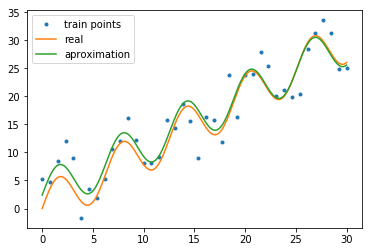

In [ ]:
plt.plot(x, Y, '.', label='train points')

x_plot = np.linspace(0, 30, num=10000)
plt.plot(x_plot, 4*np.sin(x_plot) + x_plot, label='real')

X_plot = np.vstack([np.ones_like(x_plot), x_plot, np.sin(x_plot)]).T
plt.plot(x_plot, X_plot@w, label='aproximation')

plt.legend(loc='best')
plt.show()

### Модель линейной классификации, как решать оптимизационную задачу
Линейная модель бинарной (-1 и 1) классификации:
$$
\mathfrak{F}_{bcl} = \left\{f\bigr(\mathbf{w}, \mathbf{x}\bigr)=\text{sign}\bigr(\mathbf{w}^{\mathsf{T}}\mathbf{x}\bigr)\bigr| \mathbf{w} \in \mathbb{R}^{n} \right\}.
$$
Требуется решить следующую оптимизационную задачу:
$$
\hat{\mathbf{w}} = \arg \min_{\mathbf{w} \in \mathbb{R}^n} \frac{1}{l}\sum_{i=1}^l\bigr[\mathbf{w}^{\mathsf{T}}\mathbf{x}_i \not= y_i\bigr] = \arg \min_{\mathbf{w} \in \mathbb{R}^n} \frac{1}{l}\sum_{i=1}^l\bigr[y_i\mathbf{w}^{\mathsf{T}}\mathbf{x}_i < 0 \bigr].
$$
Но вместо этой задачи оптимизации будем минимизировать верхнюю оценку:
$$
\hat{\mathbf{w}} = \arg \min_{\mathbf{w} \in \mathbb{R}^n} \frac{1}{l}\sum_{i=1}^l\text{log}_{2}\bigr(1+e^{-y_i\mathbf{w}^{\mathsf{T}}\mathbf{x}_i}\bigr)
$$

Но как ее минимизировать? Аналитическое решение найти не получится. Будем минизировать градиентными методами.

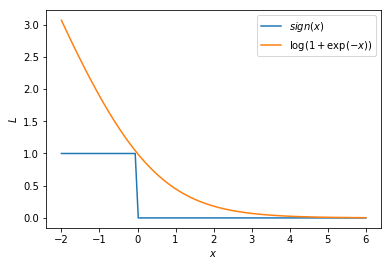

In [ ]:
def sign(x):
    return np.array(x <= 0, dtype=np.int64)
def upper_bound(x):
    return np.log2(1+np.exp(-x))

x = np.linspace(-2, 6, 100)
plt.plot(x, sign(x), label='$sign(x)$')
plt.plot(x, upper_bound(x), label='$\log(1+\exp(-x))$')

plt.xlabel('$x$')
plt.ylabel('$L$')
plt.legend(loc='best')
plt.show()

### Стохастический градиентный спуск
Напомним простой градиентный спуск:
$$
\mathbf{w}_{k+1} = \mathbf{w}_k - \alpha_k \nabla \mathcal{L}\bigr(\mathbf{w}, \mathbf{X}, \mathbf{y}\bigr).
$$
В чем минусы?
1. Очень долго считать градиент суммы $\mathcal{L}\bigr(\mathbf{w}, \mathbf{X}, \mathbf{y}\bigr) = \frac{1}{l}\sum_{i=1}^{l}q\bigr(\mathbf{w}, \mathbf{x}_i, y_i\bigr)$
2. Как ускорить?

Рассмотрим стохастический градиентный спуск:
$$
\mathbf{w}_{k+1} = \mathbf{w}_k - \alpha_k \nabla q\bigr(\mathbf{w}, \mathbf{x}_{i_k}, y_{i_k}\bigr).
$$

В случае, если индекс объекта $i_k$ сгенерирован равновероятно, то справедливо следующее свойство:
$$
\mathsf{E} \nabla q\bigr(\mathbf{w}, \mathbf{x}_{i_k}, y_{i_k}\bigr) = \frac{1}{l}\sum_{i=1}^{l}\nabla q\bigr(\mathbf{w}, \mathbf{x}_i, y_i\bigr) = \nabla\mathcal{L}\bigr(\mathbf{w}, \mathbf{X}, \mathbf{y}\bigr),
$$
то есть получаем, что в среднем градиент на каждой итерации направлен вдоль истинного градиента.

### Анализ сходимости стохастического градиента
Рассмотрим задачу оптимизации:
$$
\mathcal{L}\bigr(\mathbf{w}\bigr) = \frac{1}{l}\sum_{i=1}^{l}q\bigr(\mathbf{w}, i\bigr) \to \min_{\mathbf{w}},
$$
где $\mathcal{L}$ является выпуклой функцией по параметру $\mathbf{w}$.

Стохастический градиентный спуск:
$$
\mathbf{w}_{k+1} = \mathbf{w}_k - \alpha_k \hat{\mathbf{g}}_k, \quad \mathsf{E}\hat{\mathbf{g}}_k = \mathbf{g}_k = \nabla\mathcal{L}\bigr(\mathbf{w}\bigr).
$$

Рассмотрим норму невязки:
$$
||\textbf{w}_{k+1} - \textbf{w}^*||^2 = ||\textbf{w}_{k}-\textbf{w}^* - \alpha_{k}\hat{\textbf{g}}_k||^2 = ||\textbf{w}_{k} - \textbf{w}^*||^2 -2\alpha_{k}\hat{\textbf{g}}_k^{\mathsf{T}}(\textbf{w}_{k} - \textbf{w}^*) + \alpha_{k}^2||\hat{\textbf{g}}_k||^2.
$$

Рассмотрим среднее значение невязки при случайном выборе $\hat{\mathbf{g}}_k$:
$$
\mathsf{E}||\textbf{w}_{k+1} - \textbf{w}^*||^2 = ||\textbf{w}_{k} - \textbf{w}^*||^2 -2\alpha_{k}\textbf{g}_k^{\mathsf{T}}(\textbf{w}_{k} - \textbf{w}^*) + \alpha_{k}^2\mathsf{E}||\hat{\textbf{g}}_k||^2.
$$
Далее нам потребуется следующая величина:
$$
\alpha_{k}\textbf{g}_k^{\mathsf{T}}(\textbf{w}_{k} - \textbf{w}^*) = \frac{1}{2}||\textbf{w}_{k} - \textbf{w}^*||^2 - \frac{1}{2}\mathsf{E}||\textbf{w}_{k+1} - \textbf{w}^*||^2 + \frac{\alpha_{k}^2}{2}\mathsf{E}||\hat{\textbf{g}}_k||^2.
$$

В силу выпуклости функции $\mathcal{L}$ справедливо следующее свойство:
$$
\mathcal{L}\bigr(\mathbf{w}_k\bigr) - \mathcal{L}\bigr(\mathbf{w}^*\bigr) \leq\textbf{g}_k^{\mathsf{T}}(\textbf{w}_{k} - \textbf{w}^*)
$$

Откуда получаем:
$$
\alpha_k\left(\mathcal{L}\bigr(\mathbf{w}_k\bigr) - \mathcal{L}\bigr(\mathbf{w}^*\bigr)\right) \leq \frac{1}{2}||\textbf{w}_{k} - \textbf{w}^*||^2 - \frac{1}{2}\mathsf{E}||\textbf{w}_{k+1} - \textbf{w}^*||^2 + \frac{\alpha_{k}^2}{2}\mathsf{E}||\hat{\textbf{g}}_k||^2.
$$

Далее усредним уже по $\mathbf{w}_k$ для всех $k=0, \ldots,  K$ и просуммируем $K + 1$ первых итераций:
$$
\sum_{k=0}^{K}\alpha_k\left(\mathsf{E}\mathcal{L}\bigr(\mathbf{w}_k\bigr) - \mathcal{L}\bigr(\mathbf{w}^*\bigr)\right) \leq \frac{1}{2}||\mathbf{w}_0 - \mathbf{w}^*||^2 - \frac{1}{2}\mathsf{E}||\textbf{w}_{K+1} - \textbf{w}^*||^2 + \sum_{k=0}^{K}\frac{\alpha_{k}^2}{2}\mathsf{E}||\hat{\textbf{g}}_k||^2 \leq \frac{1}{2}||\mathbf{w}_0 - \mathbf{w}^*||^2 + \sum_{k=0}^{K}\frac{\alpha_{k}^2}{2}\mathsf{E}||\hat{\textbf{g}}_k||^2.
$$

Используем неравенство Йенсена для выпуклой функции $\mathcal{L}$:
$$
\mathsf{E}\mathcal{L}\left(\frac{1}{\sum\alpha_k}\sum\alpha_k\mathbf{w}_k\right) - \mathcal{L}\bigr(\mathbf{w}^*\bigr) \leq \sum_{k=0}^{K}\alpha_k\left(\mathsf{E}\mathcal{L}\bigr(\mathbf{w}_k\bigr) - \mathcal{L}\bigr(\mathbf{w}^*\bigr)\right) \leq \frac{1}{2}||\mathbf{w}_0 - \mathbf{w}^*||^2 + \sum_{k=0}^{K}\frac{\alpha_{k}^2}{2}\mathsf{E}||\hat{\textbf{g}}_k||^2.
$$

Для удобства введем обозначение и предположения:
$$
\hat{\mathbf{w}}_{K} = \frac{1}{\sum\alpha_k}\sum\alpha_k\mathbf{w}_k, \quad ||\textbf{w}_0 - \textbf{w}^*||^2 \leq R^2, \quad \mathsf{E}||\hat{\textbf{g}}_k||^2 \leq G^2.
$$

Получаем следующую оценку:
$$
\mathsf{E}\mathcal{L}\bigr(\hat{\mathbf{w}}_K\bigr) - \mathcal{L}\bigr(\mathbf{w}^*\bigr) \leq \frac{R^2+G^2\sum\alpha^2_k}{2\sum\alpha_k}
$$

Проанализируем выражение на скорость сходимости:
$$
\mathsf{E}\mathcal{L}\bigr(\mathbf{w}_K\bigr) - \mathcal{L}\bigr(\mathbf{w}^*\bigr) \leq \frac{R^2+G^2\sum\alpha^2_k}{2\sum\alpha_k}
$$

Первый способ выборка шага:
$$
\quad \sum\alpha_k = \infty, \quad \sum\alpha^2_k < \infty, \qquad \left[ \alpha_k = \frac{1}{k}\right]
$$
получаем скорость сходимости $\approx O\left(\frac{1}{\log K}\right)$.

Второй способ выбора шага:
$$
\quad \sum\alpha_k = \infty, \quad \frac{\sum\alpha^2_k}{\sum\alpha_k} = 0, \qquad \left[ \alpha_k = \frac{1}{\sqrt{k}}\right]
$$
получаем скорость сходимости $\approx O\left(\frac{\log K}{\sqrt{K}}\right)$.

Получили важное свойство, что при константном шаге метод стохастического градиента не сходится.

### Вернемся к задаче бинарной классификации
$$
\hat{\mathbf{w}} = \arg \min_{\mathbf{w} \in \mathbb{R}^n} \frac{1}{l}\sum_{i=1}^l\log_{2}\bigr(1+e^{-y_i\mathbf{w}^{\mathsf{T}}\mathbf{x}_i}\bigr)
$$

In [ ]:
torch.manual_seed(0)

l = 1000
n = 2

X = torch.randn([l, n])
w_true = torch.randn([n])
Y = torch.ones([l])
Y[X@w_true < 0] = -1

In [ ]:
torch.manual_seed(0)
np.random.seed(0)
w = torch.randn([n], requires_grad=True)

K = l
list_of_loss_sqrt = []
for k in range(1, K+1):
    # Считаем ошибку L на k-м шаге
    with torch.no_grad():
        list_of_loss_sqrt.append(
            torch.mean(torch.log2(1+torch.exp(-Y*(X@w)))))

    # выбираем случайный элемент из выборки
    ind = np.random.randint(low=0, high=l)
    alpha = 1/np.sqrt(k)

    # считаем ошибку на элементе
    q = torch.log2(1+torch.exp(-Y[ind]*(X[ind]@w)))

    # считаем g с крышкой
    q.backward()

    # делаем градиентный шаг
    with torch.no_grad():
        w.add_(w.grad, alpha=-1*alpha)

    # обнуляем градиент
    w.grad.zero_()

In [ ]:
pred = torch.ones([l])
pred[X@w < 0] = -1
print('Точность прогноза: {}'.format(torch.mean((pred == Y).float()).item()))

Точность прогноза: 0.9980000257492065


In [ ]:
torch.manual_seed(0)
np.random.seed(0)
w = torch.randn([n], requires_grad=True)

K = l
list_of_loss = []
for k in range(1, K+1):
    # Считаем ошибку L на k-м шаге
    with torch.no_grad():
        list_of_loss.append(torch.mean(torch.log2(1+torch.exp(-Y*(X@w)))))

    # выбираем случайный элемент из выборки
    ind = np.random.randint(low=0, high=l)
    alpha = 1/k

    # считаем ошибку на элементе
    q = torch.log2(1+torch.exp(-Y[ind]*(X[ind]@w)))

    # считаем g с крышкой
    q.backward()

    # делаем градиентный шаг
    with torch.no_grad():
        w.add_(w.grad, alpha=-1*alpha)

    # обнуляем градиент
    w.grad.zero_()

In [ ]:
torch.manual_seed(0)
w = torch.randn([n], requires_grad=True)

dataset = torch.utils.data.TensorDataset(X, Y)
generator = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

optimizer = torch.optim.SGD([w], lr=1)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer,
                                              lambda k: 1/np.sqrt(k+1))

list_of_loss_torch = []
for x, y in generator:
    optimizer.zero_grad()

    # Считаем ошибку L на k-м шаге
    with torch.no_grad():
        list_of_loss_torch.append(
            torch.mean(torch.log2(1+torch.exp(-Y*(X@w)))))

    q = torch.log2(1+torch.exp(-y*(x@w))).mean()

    q.backward()

    optimizer.step()
    scheduler.step()

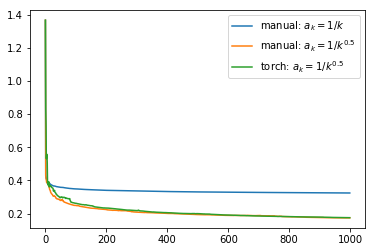

In [ ]:
plt.plot(list_of_loss, label="manual: $a_k = 1/k$")
plt.plot(list_of_loss_sqrt, label="manual: $a_k = 1/k^{0.5}$")
plt.plot(list_of_loss_torch, label="torch: $a_k = 1/k^{0.5}$")
plt.legend(loc='best')
plt.show()

## Вероятностная постановка задачи машинного обучения

### Линейная регрессия
Рассмотрим следующее вероятностное предположение о данных:
$$
y = \mathbf{w}^{\mathsf{T}}\mathbf{x} + \varepsilon, \quad \varepsilon \sim \mathcal{N}\bigr(0, \beta\bigr)
$$

Пусть векторы $\mathbf{w}$ и $\mathbf{x}$ являются неслучайными, тогда получаем, что $y$ является нормальной случайной величиной. Пусть все объекты выборки также являются независимыми случайными величинами, тогда получаем правдоподобие выборки:
$$
p\bigr(\mathbf{y}|\mathbf{w}, \mathbf{X}\bigr) = \prod_{i=1}^{l}p\bigr(y_i|\mathbf{w}, \mathbf{x}_i\bigr),
$$
где $p\bigr(y_i|\mathbf{w}, \mathbf{x}_i\bigr)=\mathcal{N}\bigr(\mathbf{w}^{\mathsf{T}}\mathbf{x}_i, \beta)$.

Принцип максимума правдоподобия:
$$
\mathcal{L}\bigr(\mathbf{w}, \mathbf{X}, \mathbf{y}\bigr) = -\sum_{i=1}^{l}\log p\bigr(y_i|\mathbf{w}, \mathbf{x}_i\bigr) = \sum_{i=1}^{l}\left[\frac{\beta}{2}\left(\mathbf{w}^{\mathsf{T}}\mathbf{x}_i-y_i\right)^2 + C\right]
$$

Данная задача эквивалентна задаче, которая была рассмотрена в начале для линейной регрессии. Решение задачи имеет вид:
$$
\hat{\mathbf{w}} = \left(\mathbf{X}^{\mathsf{T}}\mathbf{X}\right)^{-1}\mathbf{X}^{\mathsf{T}}\mathbf{y}
$$

Теперь рассмотрим совместное правдоподобие модели и данных:
$$
p\bigr(\mathbf{y}, \mathbf{w}|\mathbf{X}\bigr) = \prod_{i=1}^{l}p\bigr(y_i|\mathbf{w}, \mathbf{x}_i\bigr)p\bigr(\mathbf{w}\bigr),
$$
где для простоты рассмотрим $p\bigr(\mathbf{w}\bigr)=\mathcal{N}\bigr(\mathbf{0}, \gamma\mathbf{I})$.

По принципу максимума правдоподобия получаем следующую функцию для минимизации:
$$
\mathcal{L}\bigr(\mathbf{w}, \mathbf{X}, \mathbf{y}\bigr) = -\sum_{i=1}^{l}\log p\bigr(y_i|\mathbf{w}, \mathbf{x}_i\bigr) - \log p\bigr(\mathbf{w}\bigr) = \sum_{i=1}^{l}\left[\frac{\beta}{2}\left(\mathbf{w}^{\mathsf{T}}\mathbf{x}_i-y_i\right)^2 + C_1\right] + \mathbf{w}^{\mathsf{T}}\mathbf{w} + C_2.
$$

Заметим, что следующая задача оптимизации имеет аналитическое решение:
$$
\hat{\mathbf{w}} = \arg\min_{\mathbf{w} \in \mathbb{R}^{n}} \left\{-\sum_{i=1}^{l}\log p\bigr(y_i|\mathbf{w}, \mathbf{x}_i\bigr) - \log p\bigr(\mathbf{w}\bigr)\right\} = \arg\min_{\mathbf{w} \in \mathbb{R}^{n}} \left\{ \sum_{i=1}^{l}\left[\frac{\beta}{2}\left(\mathbf{w}^{\mathsf{T}}\mathbf{x}_i-y_i\right)^2 + C_1\right] + \frac{\gamma}{2}\mathbf{w}^{\mathsf{T}}\mathbf{w} + C_2 \right\}.
$$

### Логистическая регрессия
Рассмотрим следующее вероятностное предположение о данных:
$$
y \sim \text{Be}\bigr(\sigma\bigr(\mathbf{w}^{\mathsf{T}}\mathbf{x}\bigr)\bigr), \quad \sigma\bigr(x\bigr) = \frac{1}{1+\exp\bigr(-x\bigr)}.
$$

Принцип максимума правдоподобия:
$$
\mathcal{L}\bigr(\mathbf{w}, \mathbf{X}, \mathbf{y}\bigr) = -\sum_{i=1}^{l}\log p\bigr(y_i|\mathbf{w}, \mathbf{x}_i\bigr) = \sum_{i=1}^{l}\left[y_i\log\sigma\bigr(\mathbf{w}^{\mathsf{T}}\mathbf{x}_i\bigr) + \left(1-y_i\right)\log\left(1-\sigma\bigr(\mathbf{w}^{\mathsf{T}}\mathbf{x}_i\bigr)\right) + C\right].
$$

Аналогично рассмотрим совместное правдоподобие модели и данных. Запишем правдоподобие в случае, когда $p\bigr(\mathbf{w}\bigr)=\mathcal{N}\bigr(\mathbf{0}, \gamma\mathbf{I})$:
$$
\mathcal{L}\bigr(\mathbf{w}, \mathbf{X}, \mathbf{y}\bigr) = -\sum_{i=1}^{l}\log p\bigr(y_i|\mathbf{w}, \mathbf{x}_i\bigr) - \log p\bigr(\mathbf{w}\bigr) = \sum_{i=1}^{l}\left[y_i\log\sigma\bigr(\mathbf{w}^{\mathsf{T}}\mathbf{x}_i\bigr) + \left(1-y_i\right)\log\left(1-\sigma\bigr(\mathbf{w}^{\mathsf{T}}\mathbf{x}_i\bigr)\right) + C_1\right] + \frac{\gamma}{2}\mathbf{w}^{\mathsf{T}}\mathbf{w} + C_2.
$$

## Анализ решения задачи оптимизации от параметра $\gamma$
Заметим, что решение оптимизационной задачи зависит от параметра $\gamma$:
$$
\hat{\mathbf{w}}\bigr(\gamma\bigr) = \arg\min_{\mathbf{w} \in \mathbb{R}^{n}} \left\{\sum_{i=1}^{l}\left[y_i\log\sigma\bigr(\mathbf{w}^{\mathsf{T}}\mathbf{x}_i\bigr) + \left(1-y_i\right)\log\left(1-\sigma\bigr(\mathbf{w}^{\mathsf{T}}\mathbf{x}_i\bigr)\right)\right] + \frac{\gamma}{2}\mathbf{w}^{\mathsf{T}}\mathbf{w}\right\}.
$$

Рассмотрим решение логистической регрессии для разных параметров $\gamma$.

In [ ]:
np.random.seed(0)
l = 50000
n = 2

X = np.random.randn(l, n)
w = np.random.randn(n)
Y = np.random.binomial(n=1, p=expit(X@w))

In [ ]:
gammas = [1e-10, 1e-4, 1e-3, 1e-2, .1, 1., 10., 1e2, 1e3, 1e4, 1e10]

models_l2 = dict()
for gamma in gammas:
    model = LogisticRegression(penalty='l2', C=2/gamma, fit_intercept=False,
                               random_state=0, solver='saga')
    model.fit(X, Y)
    models_l2[gamma] = model

models_l1 = dict()
for gamma in gammas:
    model = LogisticRegression(penalty='l1', C=2/gamma, fit_intercept=False,
                               random_state=0, solver='saga')
    model.fit(X, Y)
    models_l1[gamma] = model

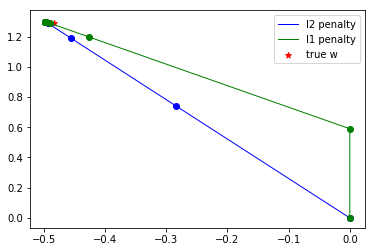

In [ ]:
x = [models_l2[gamma].coef_[0][0] for gamma in models_l2]
y = [models_l2[gamma].coef_[0][1] for gamma in models_l2]

plt.plot(x, y, 'bo')
plt.plot(x, y, 'b-', linewidth=1, label='l2 penalty')

x = [models_l1[gamma].coef_[0][0] for gamma in models_l1]
y = [models_l1[gamma].coef_[0][1] for gamma in models_l1]

plt.plot(x, y, 'go')
plt.plot(x, y, 'g-', linewidth=1, label='l1 penalty')

plt.scatter(w[0], w[1], marker='*', c='r', label='true w')
plt.legend(loc='best')
plt.show()

### Как находить оптимальное $\gamma$

### LOO

Одним из простых методов борьбы с переобучением является метод Leave One Out. Для удобства обозначим $\hat{\theta}\bigr(\mathbf{X}\bigr)$ как оптимальный вектор для выборки $\mathbf{X}$. Тогда ошибка LOO определяется следующим образом:
$$LOO\bigr(\mu, \textbf{X}_{tr}, \textbf{y}_{tr}, \textbf{X}_{vl}, \textbf{y}_{vl}\bigr) =
\sum_{i=1}^{l_{tr}+l_{vl}}q\bigr(\hat{\theta}\bigr(\mathbf{X}_{tr}\cup\textbf{X}_{vl}\setminus\mathbf{x}_i, \mu\bigr), \mathbf{x}_i, y_i\bigr),$$
где $\mathbf{x}_i$ - это элемент из объединенного датасета обучения и валидации.

После чего оптимальный вектор параметров является решением следующей оптимизационной задачи:
$$
\hat{\mu} = \arg\min_{\mu \in \mathfrak{M}} LOO\bigr(\mu, \textbf{X}_{tr}, \textbf{y}_{tr}, \textbf{X}_{vl}, \textbf{y}_{vl}\bigr),
$$
$$
\hat{\theta} = \hat{\theta}\bigr(\mathbf{X}_{tr}\cup\textbf{X}_{vl}, \hat{\mu}\bigr)
$$

Для поиска оптимального $\gamma$ вспомним про Cross Validation и LOO методы.

LOO:
$$
\hat{\gamma} = \arg\min_{\gamma \in \Gamma} LOO\bigr(\gamma, \textbf{X}_{tr}, \textbf{y}_{tr}, \textbf{X}_{vl}, \textbf{y}_{vl}\bigr), \quad LOO\bigr(\mu, \textbf{X}_{tr}, \textbf{y}_{tr}, \textbf{X}_{vl}, \textbf{y}_{vl}\bigr) =
\sum_{i=1}^{l_{tr}+l_{vl}}q\bigr(\hat{\mathbf{w}}\bigr(\gamma\bigr), \mathbf{x}_i, y_i\bigr),
$$

На лекции рассмотрим метод LOO. В Cross Validation все то же самое, но откладываем не по одному элементу, а больше.

In [ ]:
np.random.seed(0)
l = 1000
n = 2

X_train = np.random.randn(l, n)
X_test = np.random.randn(500, n)
w = np.random.randn(n)
Y_train = np.random.binomial(n=1, p=expit(X_train@w))
Y_test = np.random.binomial(n=1, p=expit(X_test@w))

In [ ]:
loo = LeaveOneOut()
number_of_batch = loo.get_n_splits(X_train)

gamma_scores = dict()
for gamma in tqdm(gammas):
    list_of_scores = []
    for train_index, test_index in tqdm(loo.split(X_train),
                                        total=number_of_batch, leave=False):
        x_train, x_test = X_train[train_index], X_train[test_index]
        y_train, y_test = Y_train[train_index], Y_train[test_index]

        model = LogisticRegression(penalty='l2', C=2/gamma, solver='saga',
                                   fit_intercept=False, random_state=0)
        model.fit(x_train, y_train)
        list_of_scores.append(model.score(x_test, y_test))

    gamma_scores[gamma] = np.mean(list_of_scores)

In [ ]:
best_gamma = sorted(gamma_scores,
                    key=lambda x: gamma_scores[x], reverse=True)[0]

model = LogisticRegression(penalty='l2', C=2/best_gamma, fit_intercept=False,
                           random_state=0, solver='saga')
model.fit(X_train, Y_train)
print('Точность: {}'.format(model.score(X_test, Y_test)))

Точность: 0.768


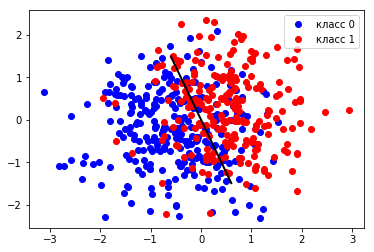

In [ ]:
cols = ['blue', 'red']

for k in np.unique(Y_test):
    plt.plot(X_test[Y_test==k,0], X_test[Y_test==k,1], 'o',
             label='класс {}'.format(k), color=cols[k])

plt.plot(*get_line(*model.coef_[0], x_min=-0.6, x_max=0.6),
         linewidth=2, color='black')

plt.legend(loc='best')
plt.show()

### Задание 1

Сгенерировать множество точек с некоторой зависимостью (на ваш выбор).

Применив линейную модель восстановить эту зависимость, выписать метрики качества (3-4 штуки).

Приветствуется визуализация

MSE  = 20.165
RMSE = 4.491
MAE  = 3.505
R^2  = 0.935


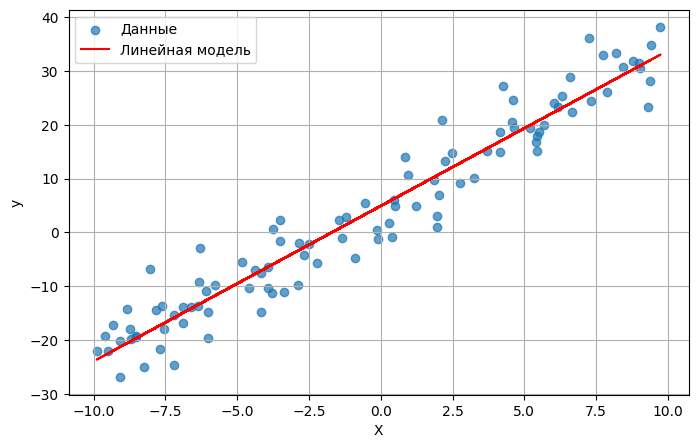

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

np.random.seed(42)

# y=3x+5+ε
X = np.random.uniform(-10, 10, size=(100, 1))
y = 3 * X.squeeze() + 5 + np.random.normal(0, 5, size=100)

model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)

mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f"MSE  = {mse:.3f}")
print(f"RMSE = {rmse:.3f}")
print(f"MAE  = {mae:.3f}")
print(f"R^2  = {r2:.3f}")

plt.figure(figsize=(8, 5))
plt.scatter(X, y, label="Данные", alpha=0.7)
plt.plot(X, y_pred, color="red", label="Линейная модель")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.grid()
plt.show()



### Задание 2

Сгенерировать множество точек 3 классов.

Применив логистическую регрессию и SVM восстановить оптимальную разделяющую гиперплоскость, выписать метрики качества (3 штуки).

Приветствуется визуализация

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression
Accuracy : 1.0
Precision: 1.0
Recall   : 1.0

SVM
Accuracy : 1.0
Precision: 1.0
Recall   : 1.0



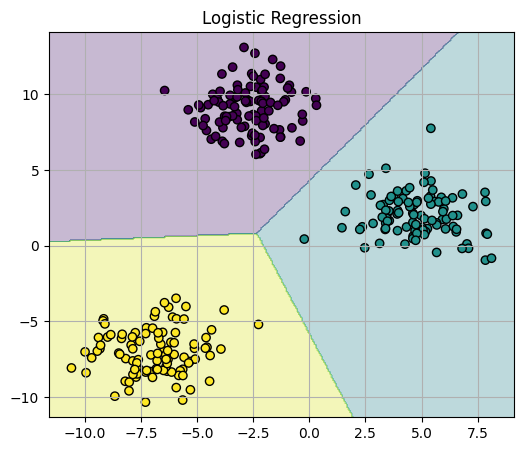

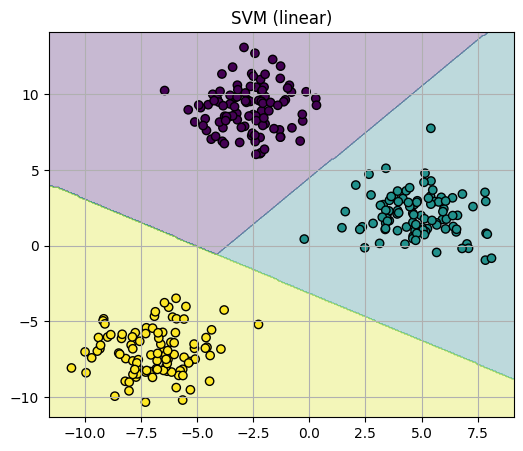

In [2]:
from sklearn.datasets import make_blobs

X, y = make_blobs(
    n_samples=300,
    centers=3,
    cluster_std=1.5,
    random_state=42
)

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score

log_reg = LogisticRegression(multi_class="multinomial", max_iter=1000)
svm = SVC(kernel="linear")

log_reg.fit(X, y)
svm.fit(X, y)

y_pred_lr = log_reg.predict(X)
y_pred_svm = svm.predict(X)

def print_metrics(name, y_true, y_pred):
    print(name)
    print("Accuracy :", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred, average="macro"))
    print("Recall   :", recall_score(y_true, y_pred, average="macro"))
    print()

print_metrics("Logistic Regression", y, y_pred_lr)
print_metrics("SVM", y, y_pred_svm)

def plot_decision_boundary(model, X, y, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(6, 5))
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor="k")
    plt.title(title)
    plt.grid()
    plt.show()

plot_decision_boundary(log_reg, X, y, "Logistic Regression")
plot_decision_boundary(svm, X, y, "SVM (linear)")
